In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
import glob


In [2]:
from scipy.ndimage import gaussian_filter1d

def smooth_data(data_to_smooth, window_size=10):
    # Create a moving average filter
    filter = np.ones(window_size) / window_size
    # Apply the filter to the response data using list comprehension
    smoothed_response = [np.convolve(trial, filter, mode='same') for trial in data_to_smooth]
    return np.squeeze(smoothed_response)

def load_and_process_data(directory_path, part_of_file_name):

    # get latest file from data folder that includes part_of_file_name in its name
    fileIs = sorted((f for f in glob.glob(f"{directory_path}/*") if part_of_file_name in f), key=os.path.getctime)[-1]

    # load the .mat file
    mat_contents = sio.loadmat(fileIs)
    print(f"Loaded {fileIs.split('_')[2]}")
    # extract the necessary data
    sigma, eyeResp, target,targetY,eyeRespY = mat_contents['sigma'],     mat_contents['eyeX'], mat_contents['blob_x'], mat_contents['blob_y'], mat_contents['eyeY']
    
    if fileIs.split('_')[2] == "both":
        mouseResp = mat_contents['mouse_x'] 
        mouseRespY = mat_contents['mouse_y']
        combinedMouseRespXY = np.sqrt(mouseResp**2 +mouseRespY**2)
        combinedMouseRespXY = combinedMouseRespXY - np.mean(combinedMouseRespXY, axis=1, keepdims=True)
        mouseResp = mouseResp - np.mean(mouseResp, axis=1, keepdims=True)
        mouseRespY = mouseRespY - np.mean(mouseRespY, axis=1, keepdims=True)

    else:
        mouseResp = None
        mouseRespY = None
        combinedMouseRespXY = None
    
    combinedEyeRespXY = np.sqrt(eyeResp**2 +eyeRespY**2)
    combinedTargetPosXY = np.sqrt(target**2 +targetY**2)


    eyeResp = eyeResp - np.mean(eyeResp, axis=1, keepdims=True)
    target = target - np.mean(target, axis=1, keepdims=True)
    targetY = targetY - np.mean(targetY, axis=1, keepdims=True)
    eyeRespY = eyeRespY - np.mean(eyeRespY, axis=1, keepdims=True)
    combinedEyeRespXY = combinedEyeRespXY - np.mean(combinedEyeRespXY, axis=1, keepdims=True)
    combinedTargetPosXY = combinedTargetPosXY - np.mean(combinedTargetPosXY, axis=1, keepdims=True)

    #eyeResp = smooth_data(eyeResp)
    #eyeRespY = smooth_data(eyeRespY)
    #combinedEyeRespXY=smooth_data(combinedEyeRespXY)

    # calculate the number of trials
    sigma=sigma.flatten()
    blob_widths = np.unique(sigma)
    nTrial = len(sigma)
    nSigma = len(blob_widths)#(nTrial - 1) // 5 + 1
    nTrialPerSigma = nTrial // nSigma

    sigma = sigma.flatten()
    return fileIs,sigma, eyeResp, target, targetY,eyeRespY,blob_widths,nTrial,nSigma,nTrialPerSigma,mouseResp,mouseRespY,combinedEyeRespXY,combinedTargetPosXY,combinedMouseRespXY


fileIs,sigma, eyeResp, target, targetY,eyeRespY,blob_widths,nTrial,nSigma,nTrialPerSigma,mouseResp,mouseRespY,combinedEyeRespXY,combinedTargetPosXY,combinedMouseRespXY = load_and_process_data("data_both", "p2_both_continous_psych_2024")
blob_widths = np.unique(sigma.flatten())
# calculate the number of trials
nTrial = len(sigma.flatten())
nSigma = (nTrial - 1) // 5 + 1
nTrialPerSigma = nTrial // nSigma
respMode='eyeResp'
print(nTrial, nSigma, nTrialPerSigma, blob_widths)
#mouseResp.shape

Loaded both
15 3 5 [11 17 25]


Loaded both


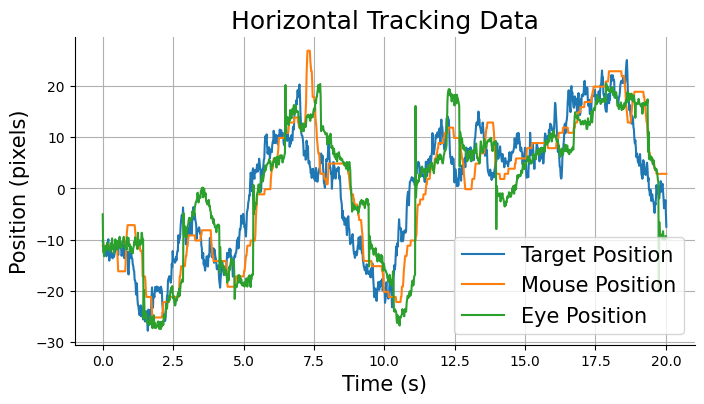

15 3 5 [11 17 25]


In [3]:
fileIs,sigma, eyeResp, target, targetY,eyeRespY,blob_widths,nTrial,nSigma,nTrialPerSigma,mouseResp,mouseRespY,combinedEyeRespXY,combinedTargetPosXY,combinedMouseRespXY = load_and_process_data("data_both", "p2_both_continous_psych_2024")

trialNum=3
plt.figure(figsize=(8,4))
# Assuming the number of frames is the length of target[trialNum,:]
num_frames = len(target[trialNum,:])
frame_rate = 60  # frames per second

# Generate a new x-axis in seconds
time_in_seconds = np.linspace(0, num_frames / frame_rate, num_frames)

# Plot using the new x-axis
plt.plot(time_in_seconds, target[trialNum,:], label='Target Position')
plt.plot(time_in_seconds, mouseResp[trialNum,:], label='Mouse Position')
plt.plot(time_in_seconds, eyeResp[trialNum,:], label='Eye Position')


#plt.plot(eyeResp[trialNum,:])
plt.legend(fontsize=15)
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Position (pixels)', fontsize=15)
# ax remove top and right spines
sns.despine()
# plt title
plt.title('Horizontal Tracking Data', fontsize=18)
# add grid
plt.grid()

plt.show()



# load the .mat file for o8

respMode='eyeRespY'
print(nTrial, nSigma, nTrialPerSigma, blob_widths)



In [6]:

# plotyly plot a figure with subplots of "targetX" vs "eyeX",and "targetY vs "eyeY" using Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with subplots
fig = make_subplots(rows=1, cols=3)
# figsize
fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
)



# Add traces
trialNum=4
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=target[trialNum,:], mode='lines', name=None, line=dict(color='darkred', width=2), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=eyeResp[trialNum,:], mode='lines', name=None, line=dict(color='royalblue', width=2), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=targetY[trialNum,:], mode='lines', name=None, line=dict(color='darkred', width=2), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=eyeRespY[trialNum,:], mode='lines', name=None, line=dict(color='royalblue', width=2), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=mouseResp[trialNum,:], mode='lines', name=None, line=dict(color='forestgreen', width=4), showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=mouseRespY[trialNum,:], mode='lines', name=None, line=dict(color='forestgreen', width=4), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=target[trialNum,:], y=targetY[trialNum,:], mode='lines', name='target', line=dict(color='darkred', width=2)), row=1, col=3)
fig.add_trace(go.Scatter(x=eyeResp[trialNum,:], y=eyeRespY[trialNum,:], mode='lines', name='eye', line=dict(color='royalblue', width=2)), row=1, col=3)
fig.add_trace(go.Scatter(x=mouseResp[trialNum,:], y=mouseRespY[trialNum,:], mode='lines', name='mouse', line=dict(color='forestgreen', width=4)), row=1, col=3)
# Update xaxis properties
fig.update_xaxes(title_text="time(Frame)", row=1, col=1)
fig.update_xaxes(range=[-10, 1260], row=1, col=1)
fig.update_xaxes(range=[-10, 1260], row=1, col=2)
fig.update_xaxes(title_text="time(Frame)", row=1, col=2)
fig.update_xaxes(title_text="X - position", row=1, col=3)

# Update xaxis properties
fig.update_xaxes(title_text="time(Frame)", row=1, col=1, range=[0, 1200], dtick=200)
fig.update_xaxes(title_text="time(Frame)", row=1, col=2, range=[0, 1200], dtick=200)
fig.update_xaxes(title_text="X - position", row=1, col=3, dtick=200)
# Update yaxis properties
fig.update_yaxes(title_text="X - position", row=1, col=1)
fig.update_yaxes(title_text="Y - position", row=1, col=2)
fig.update_yaxes(title_text="Y - position", row=1, col=3)


fig.update_layout(
    plot_bgcolor='white',
    # paper_bgcolor='black'
    # add grid
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    # grid needs to be in each subplot
    xaxis2=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    yaxis2=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    xaxis3=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    yaxis3=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')

)

# # legend name label is target, eye, mouse
fig.update_layout(legend_title_text='Legend')
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.update_layout(legend=dict(orientation="h"))
# fig.update_layout(legend=dict(x=0.5, y=1.2))
# fig.update_layout(legend=dict(x=0.5, y=1.2, bgcolor='rgba(0,0,0,0)'))
# fig.update_layout(legend=dict(x=0.5, y=1.2, bgcolor='rgba(0,0,0,0)', bordercolor='black', borderwidth=2))

# # title
fig.update_layout(title_text="Target vs Response Positions", title_x=0.5, title_font_size=20, title_font_family="Arial")

fig.show()




### -Create a dictionary for response and target

In [7]:
def create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp=None):
    # create key-value pairs for the dictionary of 30 trials
    trial_dict = {}
    for i in range(nTrial):
        trial_dict[i] = {'target': target[i,60:], 'eyeResp': eyeResp[i,60:], 'sigma': sigma[i],
                         'targetY': targetY[i,60:], 'eyeRespY': eyeRespY[i,60:],
                         'eyeXY':combinedEyeRespXY[i,60:], 'targetXY':combinedTargetPosXY[i,60:]} #my data
        if fileIs.split('_')[2] == "both":
            trial_dict[i]['mouseResp'] = mouseResp[i,60:]
            trial_dict[i]['mouseRespY'] = mouseRespY[i,60:]
            trial_dict[i]['mouseXY'] = combinedMouseRespXY[i,60:]

    # sort the dictionary by sigma
    trialDictSorted = sorted(((k, v) for k, v in trial_dict.items()), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
    tmp_trial = trialDictSorted[0][1]

    return trialDictSorted, tmp_trial

trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
print(trialDictSorted[0][1].keys())


dict_keys(['target', 'eyeResp', 'sigma', 'targetY', 'eyeRespY', 'eyeXY', 'targetXY', 'mouseResp', 'mouseRespY', 'mouseXY'])


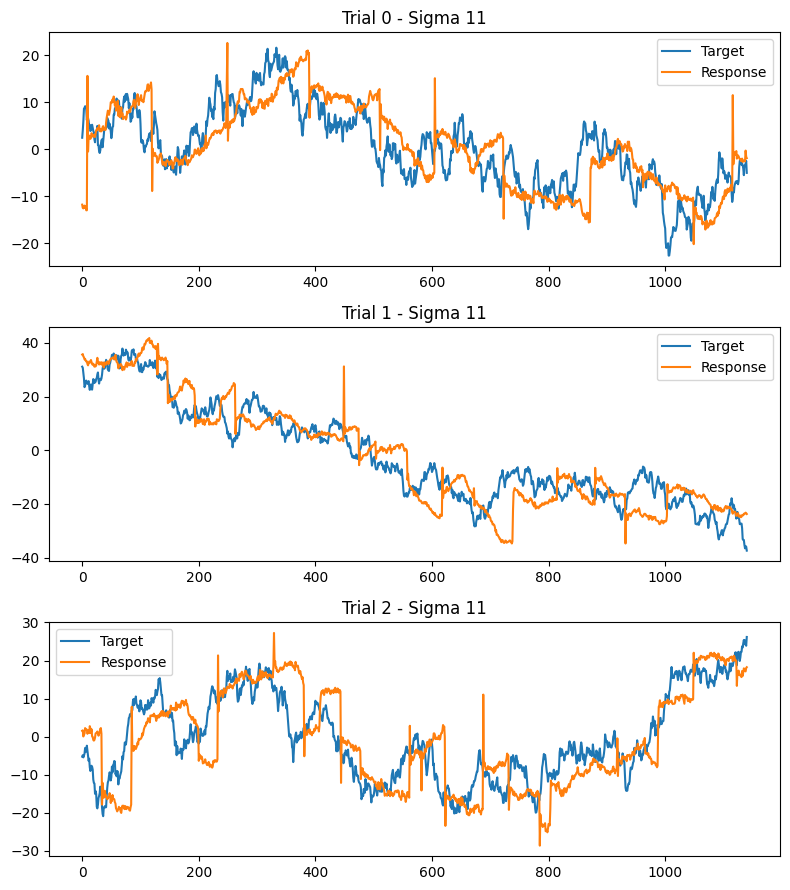

In [8]:
# plot the target and response positions for each trial on Y axis using trialdict
def plot_trial_dict(trialDictSorted, tmp_trial, nSigma, respMode='eyeRespY', targetMode='targetY'):
    # create a figure with subplots
    fig, axs = plt.subplots(nSigma, 1, figsize=(8, 3 * nSigma))

    # loop through the trials and plot the target and response positions
    for i in range(nSigma):
        trialNum = trialDictSorted[i][0]
        trial = trialDictSorted[i][1]
        axs[i].plot(trial[targetMode], label='Target')
        axs[i].plot(trial[respMode], label='Response')
        axs[i].set_title(f"Trial {trialNum} - Sigma {trial['sigma']}")
        axs[i].legend()

    plt.tight_layout()
    plt.show()

plot_trial_dict(trialDictSorted, tmp_trial, nSigma, respMode='eyeResp',targetMode='target')


## - Avarage CCG across different blob widths for single participant

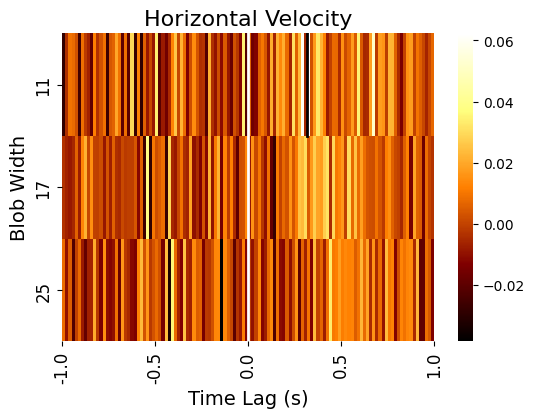

<module 'matplotlib.pyplot' from 'C:\\Users\\omeru\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
respMode='eyeResp'
targetMode='target'

plotName='Horizontal'

def calculate_ccg(X, Y):
    X = np.diff(X)
    Y = np.diff(Y)
    X = (X - np.mean(X)) / np.std(X) # take the z-score of the data
    Y = (Y - np.mean(Y)) / np.std(Y) # take the z-score of the data
    #return np.correlate(X, Y, 'full')
    ccg = np.correlate(X, Y, 'full')
    return ccg / (len(X) * np.std(X) * np.std(Y))

def calculate_ccgs_for_blob_width(trialDictSorted, blob_width, nTrialPerSigma, respModeF, targetModeF):
    ccg_single_blobs = []
    for i in range(nTrialPerSigma):
        tmp_trial = trialDictSorted[i + blob_width * nTrialPerSigma][1]
        X = tmp_trial[respModeF]
        Y = tmp_trial[targetModeF]
        ccg_single_trial = calculate_ccg(X, Y)
        ccg_single_blobs.append(ccg_single_trial)
    return ccg_single_blobs

def calculate_ccgs_for_all_blob_widths(trialDictSorted, blob_widths, nTrialPerSigma, respModeF, targetModeF):
    ccg_single_blob = []
    ccg_blob_mean = []
    for blob_width in range(len(blob_widths)):
        ccg_single_blobs = calculate_ccgs_for_blob_width(trialDictSorted, blob_width, nTrialPerSigma, respModeF, targetModeF)
        ccg_single_blob.append(ccg_single_blobs)
        ccg_blob_mean.append(np.mean(ccg_single_blob[blob_width], axis=0))
    return ccg_blob_mean, ccg_single_blob

def trim_ccgs(ccgs, len_trial, lag_range):
    ccgs = np.array(ccgs)
    return ccgs[:, len_trial - lag_range : len_trial + lag_range]

def plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range):
    plt.figure(figsize=(6, 4))
    sns.heatmap(ccg_blob_mean_trimmed, cmap='afmhot', yticklabels=blob_widths)
    x = np.linspace(0, frameRate * lag_time * 2, 5)
    labels = np.linspace(-lag_time, lag_time, len(x))
    plt.xticks(x, labels, rotation='vertical', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(plotName+' Velocity', fontsize=16)
    plt.xlabel('Time Lag (s)', fontsize=14)
    plt.ylabel('Blob Width', fontsize=14)
    plt.axvline(x=lag_range, color='white', linestyle='-', linewidth=2)
    return plt

def plot_heatmap_eachTrial(ccg_single_trials_trimmed, blob_widths, lag_range):
    plt.figure(figsize=(6, 4))
    sns.heatmap(ccg_single_trials_trimmed, cmap='afmhot')
    x = np.linspace(0, frameRate * lag_time * 2, 5)
    labels = np.linspace(-lag_time, lag_time, len(x))
    plt.xticks(x, labels, rotation='vertical', fontsize=12)
    yticks=np.linspace(0, len(ccg_single_trials_trimmed), len(blob_widths))
    yticklabels=blob_widths
    plt.yticks(yticks, yticklabels, fontsize=12)
    plt.title(str(plotName)+' Velocity', fontsize=16)
    plt.xlabel('Time Lag (s)', fontsize=14)
    plt.ylabel('Blob Width', fontsize=14)
    return plt

def find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths):
    timePoints = ccg_blob_mean_trimmed.shape[1]
    peak_indices = np.argmax(ccg_blob_mean_trimmed, axis=1)
    peak_indices = np.where(peak_indices > timePoints // 2, peak_indices, -1)
    for i, peak_index in enumerate(peak_indices):
        plt.axvline(x=peak_index, color='black', linestyle='-', linewidth=2, ymin=1 - (i / len(blob_widths)), ymax=1 - ((i + 1) / len(blob_widths)))
    plt.savefig("figures/"+str(plotName)+" AVG CCG heatmap.png")

    plt.show()




def plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths):
    plt = plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range)
    find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths)

    return plt

# Now you can use these functions in your main code
blob_widths = np.unique(sigma)
nTrialPerSigma = 5 # You need to define this
frameRate = 60
lag_time = 1
lag_range = int(lag_time * frameRate)
len_trial = len(trialDictSorted[0][1]['target'])

def process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, respModeF, targetModeF):
    ccg_blob_mean, ccg_single_blob = calculate_ccgs_for_all_blob_widths(trialDictSorted, blob_widths, nTrialPerSigma, respModeF, targetModeF)
    ccg_blob_mean = np.array(ccg_blob_mean)
    ccg_blob_mean_trimmed = trim_ccgs(ccg_blob_mean, len_trial, lag_range)
    ccg_single_blob_trimmed = trim_ccgs(ccg_single_blob, len_trial, lag_range)
    ccg_single_blob = np.array(ccg_single_blob)
    ccg_single_trials = ccg_single_blob.reshape(ccg_single_blob.shape[0]*ccg_single_blob.shape[1], ccg_single_blob.shape[2])
    ccg_single_trials_trimmed = ccg_single_trials[:, len_trial - lag_range: len_trial + lag_range]
    return ccg_blob_mean_trimmed, ccg_single_trials_trimmed,ccg_blob_mean, ccg_single_blob,ccg_single_trials

ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, 'eyeResp', 'target')

# plt = plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range)
# find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths)

plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths)
# save fig



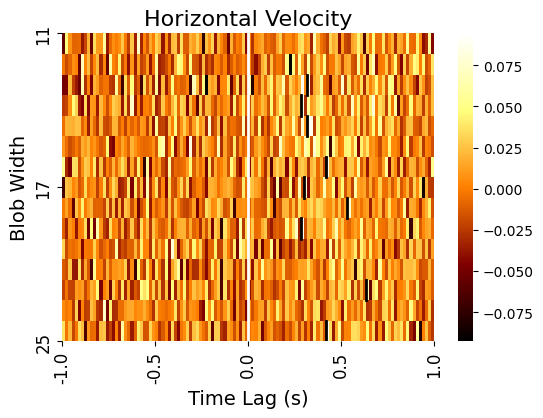

In [10]:
def find_and_plot_peak_indices_eachTrial(ccg_single_trials_trimmed, nTrial):
    timePoints = ccg_single_trials_trimmed.shape[1]
    peak_indices = np.argmax(ccg_single_trials_trimmed, axis=1)
    peak_indices = np.where(peak_indices > timePoints // 2, peak_indices, -1)
    for i, peak_index in enumerate(peak_indices):
        plt.axvline(x=peak_index, color='black', linestyle='-', linewidth=2, ymin=1-(i+1)/nTrial, ymax=1-(i)/nTrial)

def plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial):
    plot_heatmap_eachTrial(ccg_single_trials_trimmed, blob_widths, lag_time)
    find_and_plot_peak_indices_eachTrial(ccg_single_trials_trimmed, nTrial)
    plt.axvline(x=lag_range,color='white',linestyle='-',linewidth=2)
    plt.savefig("figures/"+str(plotName)+" Each CCG heatmap.png")

    plt.show()

# Now you can use this function in your main code
plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial)


In [11]:
ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, 'eyeResp', 'target')
#plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths)
#plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial)

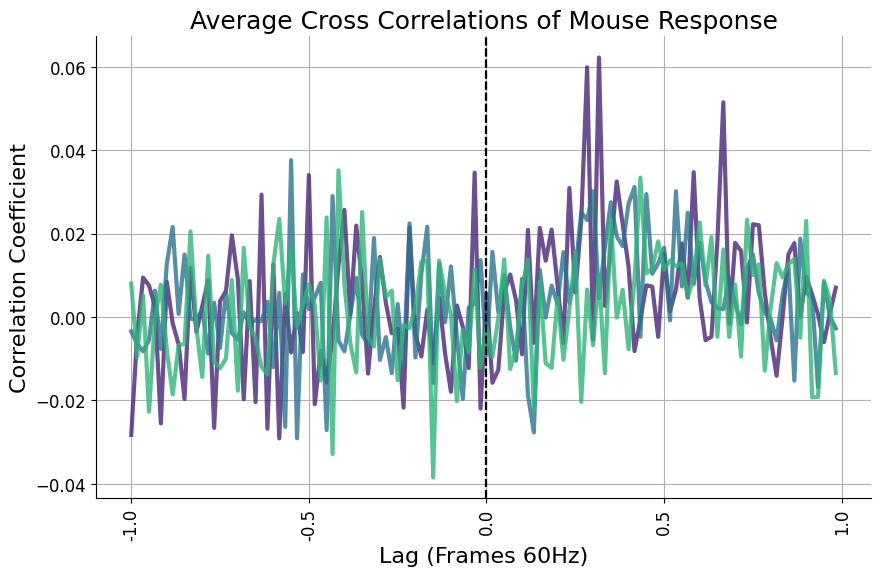

'\nFigure captions: The figure shows the average cross-correlation of the eye response with the target position for each blob width. The x-axis represents the time lag in frames (60Hz) and the y-axis represents the correlation coefficient. The vertical dashed line represents the time lag of 1 second. The average cross-correlation of the eye response with the target position is calculated for each blob width and plotted in different colors. The shaded area represents the standard error of the mean. The average cross-correlation of the eye response with the target position is highest for the smallest blob width and decreases with increasing blob width.\nThe black dashed line represents the time lag of 0 seconds. The average cross-correlation of the eye response with the target position is highest for the smallest blob width and decreases with increasing blob width.\n\nThe left figure shows the CCG of the mouse response and the right figure shows the CCG of the eye response. \nIn the figu

In [12]:
def plot_ccg(ccg, len_trial, steps, bw, linestyle,color):
    plt.plot(ccg[len_trial-steps:len_trial+steps], label=bw, linestyle=linestyle, linewidth=3, alpha=0.8, color=color)

    # better colors for the lines
def set_x_axis_ticks(time_lag, frameRate):
    x = np.linspace(0, frameRate * time_lag * 2, 5)
    labels = np.linspace(-time_lag, time_lag, len(x))
    plt.xticks(x, labels, rotation='vertical', fontsize=12)

def plot_vertical_line(time_lag, frameRate):
    plt.axvline(time_lag * frameRate, color='black', linestyle='--')

def set_plot_title_and_labels():
    plt.title('Average Cross Correlations of Mouse Response', fontsize=16)
    plt.xlabel('Lag (Frames 60Hz)', fontsize=14)
    plt.ylabel('Correlation Coefficient', fontsize=14)

def plot_mean_ccgs(blob_widths, trialDictSorted, ccg_blob_mean):
    len_trial = len(trialDictSorted[0][1]['target'])
    frameRate = 60
    time_lag = 1  # seconds
    steps = int(frameRate * time_lag)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(True)
    linestyles = ['-', '-', '-', ':']
    colors = ['blue', 'green', 'red', 'purple']
    # better colors for the lines
    cmap= plt.get_cmap('viridis')
    
    colors = cmap(np.linspace(0.1, 0.65, len(blob_widths)))
    for i, bw in enumerate(blob_widths):
        ccg = ccg_blob_mean[i]
        plot_ccg(ccg, len_trial, steps, bw, linestyles[i % len(linestyles)],colors[i])
        set_x_axis_ticks(time_lag, frameRate)
        plot_vertical_line(time_lag, frameRate)
        set_plot_title_and_labels()
    ax.legend(fontsize=14)
    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    # title size
    ax.title.set_size(18)
    # y label text size
    ax.yaxis.label.set_size(16)
    # x label text size
    ax.xaxis.label.set_size(16)
    # Set x-axis limits
    #ax.set_xlim([frameRate * time_lag , frameRate * time_lag * 2])
    # off legend
    ax.legend().set_visible(False)

    plt.show()

plot_mean_ccgs(blob_widths, trialDictSorted, ccg_blob_mean)


# Figure 2: Plot the average cross-correlation of the eye response with the target position for each blob width
"""
Figure captions: The figure shows the average cross-correlation of the eye response with the target position for each blob width. The x-axis represents the time lag in frames (60Hz) and the y-axis represents the correlation coefficient. The vertical dashed line represents the time lag of 1 second. The average cross-correlation of the eye response with the target position is calculated for each blob width and plotted in different colors. The shaded area represents the standard error of the mean. The average cross-correlation of the eye response with the target position is highest for the smallest blob width and decreases with increasing blob width.
The black dashed line represents the time lag of 0 seconds. The average cross-correlation of the eye response with the target position is highest for the smallest blob width and decreases with increasing blob width.

The left figure shows the CCG of the mouse response and the right figure shows the CCG of the eye response. 
In the figure below we plot the average cross-correlation of the eye response with the target position for each blob width. The x-axis represents the time lag in frames (60Hz) and the y-axis represents the correlation value. 
With smaller blob widths, the peak of the cross-correlation occurs at a shorter time lag, indicating a stronger relationship between the eye response and the target position. 
As the blob width increases, the peak of the cross-correlation shifts to longer time lags, indicating that response to the motion of target is delayed. 
However we also observe that the width of the cross correlogram is wider for larger blob widths, indicating that the response to the motion of the target is more variable and less consistent.
This plots indeed presents the same information as with the heatmap, but in a more compact and easier to interpret way. 

To further have a measure of these plots we fitted a gaussian model (Log-Gaussian) to the cross-correlation function and extracted the peak of the gaussian to have a better understanding of the time lag at which the peak of the cross-correlation occurs.
In this case amplitude of the gaussian is the correlation value at the peak of the cross-correlation function and more importantly the width of the gaussian might be used as a parameter representing the visual uncertainty of the target. 
The width of the gaussian is the standard deviation of the gaussian and it represents the variability of the response to the motion of the target.
Instead of using the pure gaussian model, we used a log-gaussian model to fit the cross-correlation as the cross-correlation is not symmetric and the log-gaussian model is more flexible to capture the asymmetry of the cross-correlation function.
The log-gaussian model is defined as:
f(x) = exp(a - (x - b)^2 / (2c^2))
where a is the amplitude, b is the peak of the cross-correlation and c is the width of the cross-correlation.



"""



In [13]:
def single_ccg_taker(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind][0]
    return ccg

def within_blob_ccgs(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind,:,:]
    ccgs_flat=ccg.flatten()
    return ccgs_flat

def single_trial_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    trial=trialDictSorted[blob_ind][1]
    return trial
def single_blob_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    blob=trialDictSorted[blob_ind:blob_ind+nTrialPerSigma]
    return blob

Loaded eye


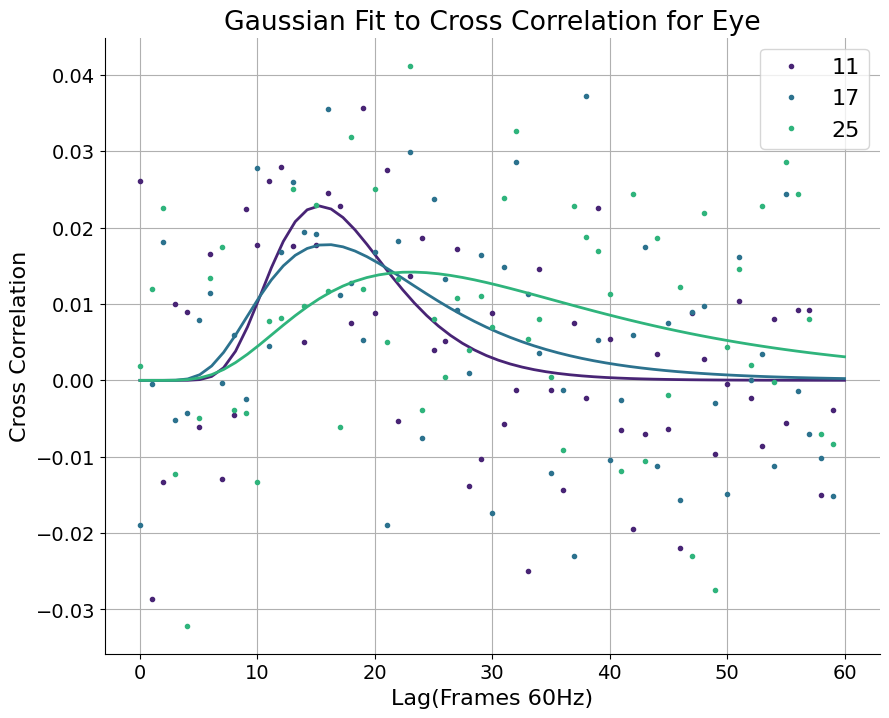

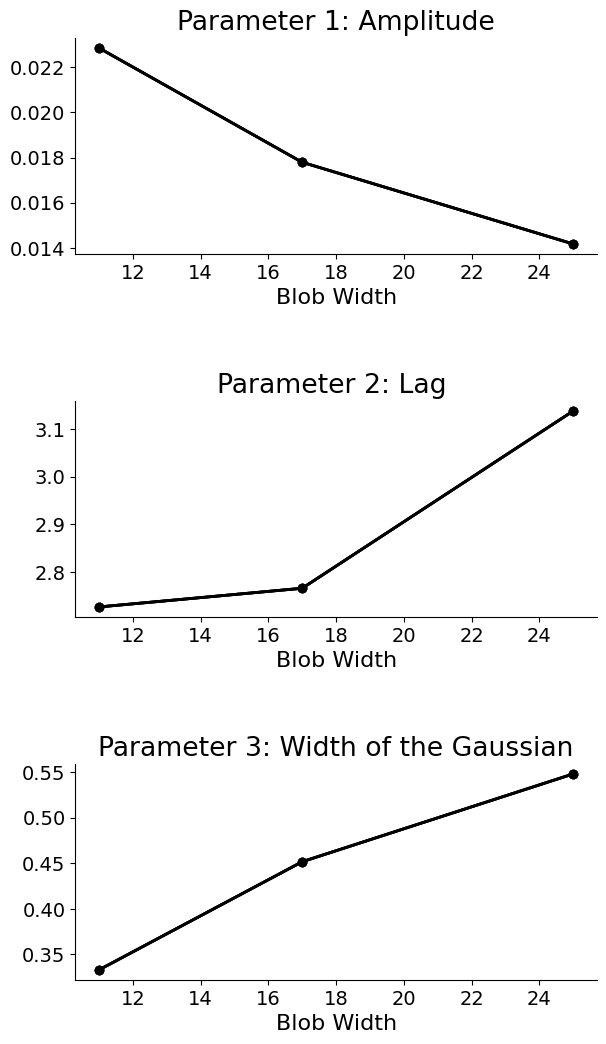

In [100]:
# load data p2
fileIs,sigma, eyeResp, target, targetY,eyeRespY,blob_widths,nTrial,nSigma,nTrialPerSigma,mouseResp,mouseRespY,combinedEyeRespXY,combinedTargetPosXY,combinedMouseRespXY = load_and_process_data("data_eye", "p9")
# create trial dict
trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
# calculate ccgs    
ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, 'eyeXY', 'targetXY')

frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
from scipy.optimize import curve_fit
import math
dashedLine=False
blob_ind=2
ccg=ccg_blob_mean[blob_ind]
mid_point = len(ccg) // 2
ydata=ccg[mid_point:mid_point+steps]
xdata= np.linspace(0, len(ydata), len(ydata))

def gaussian(x, alpha, beta, sigma):
    eplsilon=1e-100 #small constant
    return alpha * np.exp(-(x - beta) ** 2 / (2 * (sigma ** 2)))

def double_gaussian(x, alpha1, beta1, sigma1, alpha2, beta2, sigma2): #second sum of gaussian is for handling negative correlation values
    return alpha1 * np.exp(-(x - beta1) ** 2 / (2 * (sigma1 ** 2))) + alpha2 * np.exp(-(x - beta2) ** 2 / (2 * (sigma2 ** 2)))

def plot_data_and_fit(xdata, ydata, popt,color,alpha,lw=2):
    #plt.plot(xdata, ydata, 'b+:', label='data')
    yFit = gaussian(xdata, *popt)
    if dashedLine==True:
        plt.plot(xdata, yFit,color=color,alpha=alpha,lw=lw,linestyle=':')
    else:
        plt.plot(xdata, yFit,color=color,alpha=alpha,lw=lw,linestyle='-')
    if legendON:
        plt.legend()
    else:
        pass
    plt.title('Gaussian Fit to Cross Correlation for Eye')
    plt.xlabel('Lag(Frames 60Hz)',fontsize=16)
    plt.ylabel('Cross Correlation',fontsize=16)
    # y label text size

def plot_ccg_avg(ccg, steps, bw, color,alpha):
    mid_point = len(ccg) // 2
    ydata = ccg[mid_point:mid_point+steps]
    xdata = np.linspace(0, len(ydata), len(ydata))
    plt.plot(ccg[mid_point:mid_point+steps],'o', label=bw, markersize=3, color=color, alpha=alpha)
    #plt.legend()
    plt.title('Avarage Cross Correlations')
    # ax top and right border removed
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # add grid
    plt.grid(True)




def gaussian(x, alpha, beta, sigma):
    epsilon = 1e-100  # small constant to avoid log(0)
    x_positive = np.log(np.abs(x) + epsilon)  # Ensure x is positive for log
    return alpha * np.exp(-(x_positive - beta) ** 2 / (2 * (sigma ** 2)))

def fit_gaussian(xdata, ydata):
    # Ensure xdata is positive
    xdata_positive = np.abs(xdata) + 1  # Shift xdata to be strictly positive
    xdatalogPositive = np.log(xdata_positive)
    
    # Initial guesses and bounds need to be adjusted considering the log transformation
    initial_guesses = [np.max(ydata), np.mean(xdatalogPositive), np.std(xdatalogPositive)]
    bounds = ([0, np.min(xdatalogPositive), 0], [np.max(ydata), np.max(xdatalogPositive), np.max(xdatalogPositive) - np.min(xdatalogPositive)])
    
    popt, pcov = curve_fit(gaussian, xdata_positive, ydata, p0=initial_guesses, bounds=bounds)
    return popt, pcov

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Increase the size of the plot
plt.figure(figsize=(10, 8))

# Increase the size of the text and tick labels
plt.rcParams.update({'font.size': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14})

#

# Generate a colormap
colors = cm.viridis(np.linspace(0.1, 0.65, len(blob_widths)))
lineWidth=2
LineStyle='o-'
def plot_subplots(blob_widths, data, axs,alpha,color):
    popt_list,popt_covs=process_ccg_data(blob_widths, data, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=1,lw=2, shouldPlot=False)
    
    for i, hah in enumerate(colors):
        axs[0].plot(blob_widths, [popt[0] for popt in popt_list],LineStyle  ,alpha=alpha,color=color,lw=lineWidth)
        axs[0].set_title('Parameter 1: Amplitude')
        axs[0].set_xlabel('Blob Width')

        axs[1].plot(blob_widths, [popt[1] for popt in popt_list],LineStyle, alpha=alpha,color=color,lw=lineWidth)
        axs[1].set_title('Parameter 2: Lag ')
        axs[1].set_xlabel('Blob Width')

        axs[2].plot(blob_widths, [popt[2] for popt in popt_list], LineStyle,alpha=alpha,color=color,lw=lineWidth)
        axs[2].set_title('Parameter 3: Width of the Gaussian')
        axs[2].set_xlabel('Blob Width')

def process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=0.5,lw=2, shouldPlot=True):
    popt_list = []
    pcov_list = []
    for i, bw in enumerate(blob_widths): 
        ccg = ccg_blob_mean[i]
        mid_point = len(ccg) // 2
        ydata = ccg[mid_point:mid_point+steps]
        xdata = np.linspace(0, len(ydata), len(ydata))
        popt, pcov = fit_gaussian(xdata, ydata)
        if shouldPlot:
            plot_ccg_avg(ccg, steps, bw, colors[i],alpha=alpha)
            plot_data_and_fit(xdata, ydata, popt,color=colors[i],alpha=alpha,lw=lw)
        else:
            pass
        popt_list.append(popt)
        pcov_list.append(pcov)
    return popt_list, pcov_list
legendON=True
process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=1,lw=2)


fig, axs = plt.subplots(3, 1)
# Increase the size of the plot
fig.set_size_inches(8, 12)
# increase the space between the plots

fig.tight_layout(pad=5.0)

# Remove top and right borders
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#fig.tight_layout(pad=40.0)

plot_subplots(blob_widths, ccg_blob_mean, axs,alpha=1,color='black')


In [20]:
import matplotlib.cm as cm
# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')
# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)
# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

C:\Users\omeru\AppData\Local\Temp\ipykernel_30564\3465939236.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [21]:
file_list = os.listdir("data_both")
from scipy.optimize import curve_fit
import math
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
file_list[0]

'p0_both_185776_continous_psych_2024-03-11_11h48.21.062.mat'

Loaded eye
data_eye\p0_eye_continous_psych_2024-03-13_17h07.33.136.mat
Loaded eye
data_eye\p1_eye_845173_continous_psych_2024-03-11_13h33.06.419.mat
Loaded eye
data_eye\p2_eye_082553_continous_psych_2024-03-12_11h45.59.032.mat
Loaded eye
data_eye\p3_eye_continous_psych_2024-03-18_13h27.47.652.mat
Loaded eye
data_eye\p4_eye_continous_psych_2024-03-18_13h40.31.516.mat
Loaded eye
data_eye\p5_eye_continous_psych_2024-03-19_17h37.54.284.mat
Loaded eye
data_eye\p6_eye_continous_psych_2024-03-19_17h56.38.843.mat
Loaded eye
data_eye\p7_eye_continous_psych_2024-03-20_15h22.57.865.mat
Loaded eye
data_eye\p8_eye_continous_psych_2024-03-20_16h17.11.982.mat
Loaded both
data_both\p0_both_185776_continous_psych_2024-03-11_11h48.21.062.mat
Loaded both
data_both\p1_both_611451_continous_psych_2024-03-11_13h41.04.590.mat
Loaded both
data_both\p2_both_continous_psych_2024-03-14_13h19.39.509.mat
Loaded both
data_both\p3_both_continous_psych_2024-03-18_13h20.14.141.mat
Loaded both
data_both\p4_both_contino

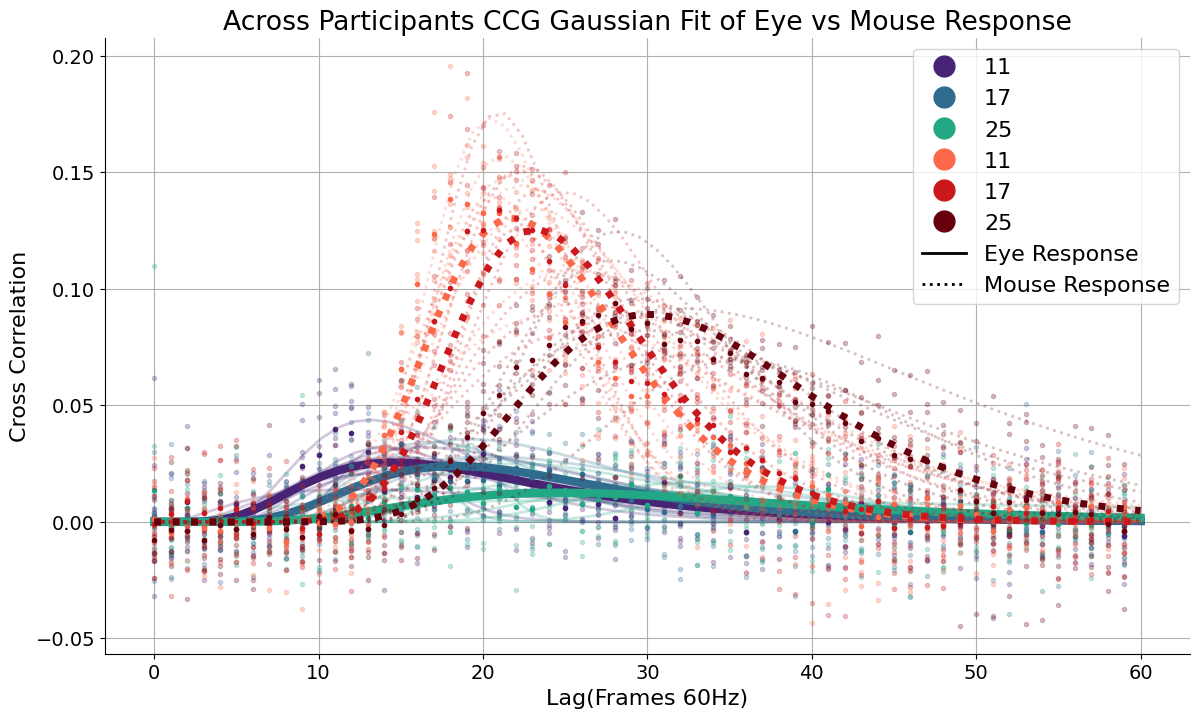

In [103]:
# file list in data_both
import matplotlib.lines as mlines

file_list = os.listdir("data_both")
from scipy.optimize import curve_fit
import math
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
# Create the plot before the loop
#fig, ax = plt.subplots()
plt.figure(figsize=(14,8))
avgCCGBlobMeansAcrossParticipants = []
avgCCGSingleTrialsAcrossParticipants=[]
avgCCGSingleBlobsAcrossParticipants=[]
avgCCGSingleTrialsTrimmedAcrossParticipants=[]
avgCCGSingleBlobsTrimmedAcrossParticipants=[]

legendON=False
dashedLine=False
colors = cm.viridis(np.linspace(0.1, 0.6, len(blob_widths)))
colors2 = cm.Reds(np.linspace(0.5, 1, len(blob_widths)))
#append colors
colors=np.append(colors,colors2)
colors=np.reshape(colors,(len(blob_widths)*2,4))

labels = ['11', '17', '25','11', '17', '25']  # Adjust as needed

# Create Line2D objects for the legend
# Add additional Line2D objects for the eye and mouse responses
lines = [mlines.Line2D([], [], color=color, marker='o', markersize=15, label=label, linestyle='None') for color, label in zip(colors, labels)]
eye_line = mlines.Line2D([], [], color='black', lw=2, label='Eye Response')
mouse_line = mlines.Line2D([], [], color='black', lw=2, linestyle=':', label='Mouse Response')

lines += [eye_line, mouse_line]
for fileName in ["eyeResp","mouseResp"]:
    
    avgCCGBlobMeansAcrossParticipants = []
    avgCCGSingleTrialsAcrossParticipants=[]
    avgCCGSingleBlobsAcrossParticipants=[]
    avgCCGSingleTrialsTrimmedAcrossParticipants=[]
    avgCCGSingleBlobsTrimmedAcrossParticipants=[]
    if fileName == "eyeResp":
        respMode='eyeResp'
        folderName="data_eye"
        dashedLine=False
        lw=6
        LineStyle='o-'
        paramColor="orangered"
    elif fileName == "mouseResp":
        respMode='mouseResp'
        folderName="data_both"
        fileName="mouseResp"
        colors = cm.Reds(np.linspace(0.5, 1, len(blob_widths)))
        # reds
        dashedLine=True
        lw=5
        paramColor="forestgreen"
        LineStyle='o--'
    for fileN in range(len(file_list)-1):
        randomColorCode = np.random.rand(3,)
        #colors = cm.viridis(np.linspace(0.1, 0.65, len(blob_widths)))

        fileIs,sigma, eyeResp, target, targetY,eyeRespY,blob_widths,nTrial,nSigma,nTrialPerSigma,mouseResp,mouseRespY,combinedEyeRespXY,combinedTargetPosXY,combinedMouseRespXY =  load_and_process_data(folderName, 'p'+str(fileN))
        print(fileIs)
        trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
        ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, respMode, 'target')
        avgCCGBlobMeansAcrossParticipants.append(ccg_blob_mean)
        avgCCGSingleTrialsAcrossParticipants.append(ccg_single_trials)
        avgCCGSingleBlobsAcrossParticipants.append(ccg_single_blob)
        avgCCGSingleTrialsTrimmedAcrossParticipants.append(ccg_single_trials_trimmed)
        avgCCGSingleBlobsTrimmedAcrossParticipants.append(ccg_blob_mean_trimmed)

        # plot the average CCG for each participant

        process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots,alpha=0.25)


    #plt.legend()
    #plt.show()

    # now plot the average CCG across all participants
    avgCCGBlobMeansAcrossParticipants = np.array(avgCCGBlobMeansAcrossParticipants)
    avgCCGSingleTrialsAcrossParticipants = np.array(avgCCGSingleTrialsAcrossParticipants)
    avgCCGSingleBlobsAcrossParticipants = np.array(avgCCGSingleBlobsAcrossParticipants)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.array(avgCCGSingleTrialsTrimmedAcrossParticipants)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.array(avgCCGSingleBlobsTrimmedAcrossParticipants)

    avgCCGBlobMeansAcrossParticipants = np.mean(avgCCGBlobMeansAcrossParticipants, axis=0)
    avgCCGSingleTrialsAcrossParticipants = np.mean(avgCCGSingleTrialsAcrossParticipants, axis=0)
    avgCCGSingleBlobsAcrossParticipants = np.mean(avgCCGSingleBlobsAcrossParticipants, axis=0)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.mean(avgCCGSingleTrialsTrimmedAcrossParticipants, axis=0)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.mean(avgCCGSingleBlobsTrimmedAcrossParticipants, axis=0)

    alpha=1
    legendON=False
    process_ccg_data(blob_widths, avgCCGBlobMeansAcrossParticipants, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots,alpha=1,lw=lw)


    legendON=False
    plt.title('Across Participants CCG Gaussian Fit of Eye vs Mouse Response')

# Add the legend at the end of your code
plt.legend(handles=lines, loc='best')
plt.show()


Loaded both
data_both\p0_both_185776_continous_psych_2024-03-11_11h48.21.062.mat
Loaded both
data_both\p1_both_611451_continous_psych_2024-03-11_13h41.04.590.mat
Loaded both
data_both\p2_both_continous_psych_2024-03-14_13h19.39.509.mat
Loaded both
data_both\p3_both_continous_psych_2024-03-18_13h20.14.141.mat
Loaded both
data_both\p4_both_continous_psych_2024-03-18_13h50.20.034.mat
Loaded both
data_both\p5_both_continous_psych_2024-03-19_17h24.17.321.mat
Loaded both
data_both\p6_both_continous_psych_2024-03-19_18h07.48.922.mat
Loaded both
data_both\p7_both_continous_psych_2024-03-20_15h09.33.361.mat
Loaded both
data_both\p8_both_continous_psych_2024-03-20_16h28.06.062.mat
Loaded both
data_both\p0_both_185776_continous_psych_2024-03-11_11h48.21.062.mat
Loaded both
data_both\p1_both_611451_continous_psych_2024-03-11_13h41.04.590.mat
Loaded both
data_both\p2_both_continous_psych_2024-03-14_13h19.39.509.mat
Loaded both
data_both\p3_both_continous_psych_2024-03-18_13h20.14.141.mat
Loaded bot

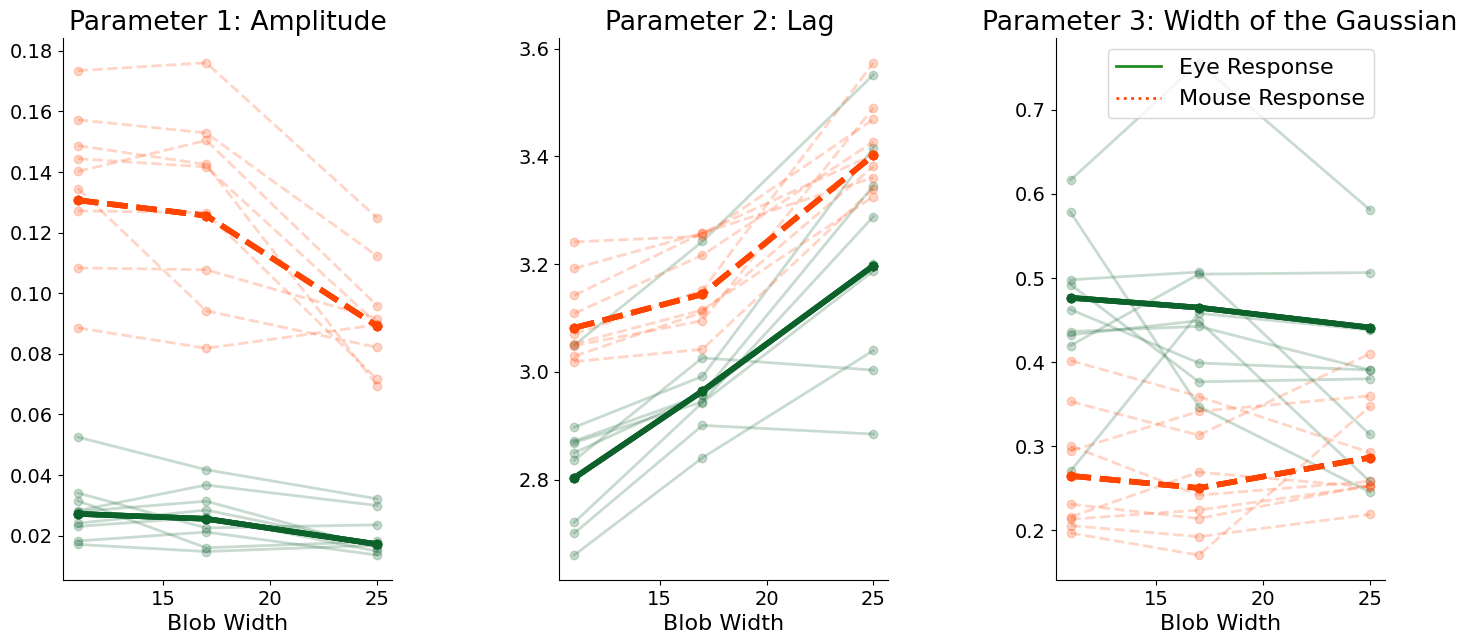

In [101]:

fig, axs = plt.subplots(1,3)
# Increase the size of the plot
fig.set_size_inches(16, 8)
# increase the space between the plots

fig.tight_layout(pad=5.0)

# Remove top and right borders
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# plot the average CCG subplot parameters for each participant

GaussianFitParams = []

for fileName in ["eyeResp","mouseResp"]:
    
    avgCCGBlobMeansAcrossParticipants = []
    avgCCGSingleTrialsAcrossParticipants=[]
    avgCCGSingleBlobsAcrossParticipants=[]
    avgCCGSingleTrialsTrimmedAcrossParticipants=[]
    avgCCGSingleBlobsTrimmedAcrossParticipants=[]
    if fileName == "eyeResp":
        respMode='eyeResp'
        folderName="data_both"
        dashedLine=False
        lw=6
        LineStyle='o-'
        paramColor="#0d622c"
    elif fileName == "mouseResp":
        respMode='mouseResp'
        folderName="data_both"
        fileName="mouseResp"
        #colors = cm.plasma(np.linspace(0.1, 0.65, len(file_list)))
        # reds
        dashedLine=True
        lw=5
        paramColor= "orangered"
        LineStyle='o--'
    for fileN in range(len(file_list)-1):
        randomColorCode = np.random.rand(3,)
        #colors = cm.viridis(np.linspace(0.1, 0.65, len(blob_widths)))

        fileIs,sigma, eyeResp, target, targetY,eyeRespY,blob_widths,nTrial,nSigma,nTrialPerSigma,mouseResp,mouseRespY,combinedEyeRespXY,combinedTargetPosXY,combinedMouseRespXY =  load_and_process_data(folderName, 'p'+str(fileN))
        print(fileIs)
        trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
        ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, respMode, 'target')
        popt_list,popt_covs=process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=0.2,lw=2, shouldPlot=False)
        GaussianFitParams.append(popt_list)
        plot_subplots(blob_widths, ccg_blob_mean, axs,alpha=0.08,color=paramColor)
        avgCCGBlobMeansAcrossParticipants.append(ccg_blob_mean)
        avgCCGSingleTrialsAcrossParticipants.append(ccg_single_trials)
        avgCCGSingleBlobsAcrossParticipants.append(ccg_single_blob)
        avgCCGSingleTrialsTrimmedAcrossParticipants.append(ccg_single_trials_trimmed)
        avgCCGSingleBlobsTrimmedAcrossParticipants.append(ccg_blob_mean_trimmed)
    # now plot the average CCG across all participants
    avgCCGBlobMeansAcrossParticipants = np.array(avgCCGBlobMeansAcrossParticipants)
    avgCCGSingleTrialsAcrossParticipants = np.array(avgCCGSingleTrialsAcrossParticipants)
    avgCCGSingleBlobsAcrossParticipants = np.array(avgCCGSingleBlobsAcrossParticipants)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.array(avgCCGSingleTrialsTrimmedAcrossParticipants)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.array(avgCCGSingleBlobsTrimmedAcrossParticipants)

    avgCCGBlobMeansAcrossParticipants = np.mean(avgCCGBlobMeansAcrossParticipants, axis=0)
    avgCCGSingleTrialsAcrossParticipants = np.mean(avgCCGSingleTrialsAcrossParticipants, axis=0)
    avgCCGSingleBlobsAcrossParticipants = np.mean(avgCCGSingleBlobsAcrossParticipants, axis=0)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.mean(avgCCGSingleTrialsTrimmedAcrossParticipants, axis=0)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.mean(avgCCGSingleBlobsTrimmedAcrossParticipants, axis=0)

        
    lineWidth=4
    plot_subplots(blob_widths, avgCCGBlobMeansAcrossParticipants, axs,alpha=1,color=paramColor)
    lineWidth=2
# custom legend for eye and mouse response
eye_line = mlines.Line2D([], [], color='forestgreen', lw=2, label='Eye Response')
mouse_line = mlines.Line2D([], [], color='orangered', lw=2, linestyle=':', label='Mouse Response')
lines = [eye_line, mouse_line]
plt.legend(handles=lines, loc='best')

plt.show()




## - Save fitting parameters

In [ ]:
import os
os.listdir()

['.git',
 'conditions.ipynb',
 'conditions.npy',
 'create_conditions.py',
 'dva_to_pix.py',
 'recorded',
 'cont_psych_simpler_.py',
 '__pycache__',
 'lam.py',
 '1_data.csv',
 'data',
 'analysis_primier.ipynb',
 'analysis_m.m',
 'README.md',
 'analysis_26092023.ipynb',
 'tracking2graphs.m',
 'negLogLikelihoodr.m',
 'data.mat',
 'example.fig',
 'omer_pilot_2.mat',
 'audio_cue.py',
 'panning_beep_beep_beep.wav',
 'beep_beep_beep.wav',
 'right.wav',
 'left.wav',
 'audio_player_psychopy.py',
 'builder_coder',
 'example_trial.mp4',
 'audio_visual_target_tracking.py',
 'continous_psychophysics_moseTrackerDumb.py',
 '.vscode',
 'simple_tracker_experiment_0.py',
 'pyimagesearch',
 'simple_tracker_experiment_openCv.py',
 'Non included tuts',
 'eye_tracking_1.py',
 'Eye_tracking_continuous_psych.py',
 'et_data.EDF',
 'NoiseGenerator.py',
 'lqg straub analysis adaptation.ipynb',
 'data_eye',
 'data_both',
 'p0_eye_180076_continous_psych_2024-03-08_10h28.12.835.mat',
 'analysis_eye_mouse.ipynb',
 '

In [ ]:
# import pandas as pd
# df=pd.read_csv('df_final.csv')

In [ ]:
# # summary df_all
# from plotly import __version__
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
# import plotly.offline as pyo
# import plotly.graph_objs as go
# from plotly.offline import iplot
# from scipy import stats
# import math

In [ ]:
respMode= np.repeat("eyeOnly",60)
respMode[30:]= "mouse"
respMode.shape




(60,)

In [ ]:
GaussianFitParams = np.array(GaussianFitParams)
amplitude = GaussianFitParams[:,:,0]
lag = GaussianFitParams[:,:,1]
width = GaussianFitParams[:,:,2]
respMode= np.repeat("eyeOnly",30)
import pandas as pd

df = pd.DataFrame(data=amplitude, columns=blob_widths)

# Reshape the DataFrame from wide format to long format
df_amplitude = df.melt(value_vars=blob_widths, var_name='blob_widths', value_name='amplitude')
df_amplitude

# Create and reshape the 'lag' DataFrame

df_lag = pd.DataFrame(data=lag, columns=blob_widths)
df_lag_melted = df_lag.melt(value_vars=blob_widths, var_name='blob_widths', value_name='lag')

# Create and reshape the 'width' DataFrame
df_width = pd.DataFrame(data=width, columns=blob_widths)
df_width_melted = df_width.melt(value_vars=blob_widths, var_name='blob_widths', value_name='width')

# Concatenate the 'amplitude', 'lag', and 'width' DataFrames
df_final = pd.concat([df_amplitude, df_lag_melted['lag'], df_width_melted['width']], axis=1)
df_final

df_final['participant'] = np.tile(np.arange(0,10,1),6)
respMode= np.repeat("eyeOnly",60)
respMode[30:]= "mouse"
respMode.shape
df_final['respMode'] = respMode





ValueError: Length of values (60) does not match length of index (54)

In [ ]:

# Fit the ANOVA models
model_amp = ols('amplitude ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final).fit()
model_lag = ols('lag ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final).fit()
model_width = ols('width ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final).fit()

# Perform the ANOVAs
anova_results_amp = anova_lm(model_amp)
anova_results_lag = anova_lm(model_lag)
anova_results_width = anova_lm(model_width)

print(anova_results_amp)
print(anova_results_lag)
print(anova_results_width)

NameError: name 'ols' is not defined

# Kalman filter

In [ ]:
from scipy.sparse import diags
import scipy.optimize as opt
def negLogLikelihood(rr, Q, X, Xhat):
    numTrials = X.shape[1]  # number of trials
    N = X.shape[0]          # number of samples

    rr = np.exp(rr)  # exponentiate observation noise variance
    pp = Q / 2 * (np.sqrt(1 + 4 * rr / Q) - 1)  # posterior variance - Eq B8
    k = (pp + Q) / (pp + Q + rr)  # Kalman Gain - eq B10
    
    # Create a sparse matrix for D
    d = diags([np.ones(N), (k - 1) * np.ones(N)], [0, -1], shape=(N, N)).toarray()  # Eq B12

    # Compute nLL using list comprehension
    nLL = -sum(-1 / (2 * k**2 * rr) * np.dot((np.dot(d, Xhat[:, i]) - k * X[:, i]).T, np.dot(d, Xhat[:, i]) - k * X[:, i]) - N / 2 * np.log(rr) - N * np.log(k) for i in range(numTrials))

    return nLL
from scipy.optimize import minimize






In [ ]:
import matplotlib.cm as cm
import numpy as np
# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')
# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)
# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

C:\Users\omeru\AppData\Local\Temp\ipykernel_21588\2822273860.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Loaded both
data_both\p0_both_185776_continous_psych_2024-03-11_11h48.21.062.mat
0
Optimal value for observation noise variance is 2.7557772189831686
Optimal value for observation noise variance is 2.505789263268448
Optimal value for observation noise variance is 2.335855746572428
Loaded eye
data_eye\p0_eye_continous_psych_2024-03-13_17h07.33.136.mat
0
Optimal value for observation noise variance is 2.7372289657771103
Optimal value for observation noise variance is 2.522448860882362
Optimal value for observation noise variance is 2.6125567961794336
Loaded both
data_both\p1_both_611451_continous_psych_2024-03-11_13h41.04.590.mat
1
Optimal value for observation noise variance is 2.749641439455426
Optimal value for observation noise variance is 2.4838223076580115
Optimal value for observation noise variance is 2.3480299191195897
Loaded eye
data_eye\p1_eye_845173_continous_psych_2024-03-11_13h33.06.419.mat
1
Optimal value for observation noise variance is 2.8182236956572875
Optimal value f

' \nTo further retrieve a single better measure of visual uncertainty about the target we fit the Kalman filter to the position data. As we have described in the introduction Kalman filter uses a moving avarage like Bayesian algorithm to estimate the future states of the system. Here we reverse correlate this model using fitting with the given responses and try to retrieve observed noise variance which we refer as positional uncertainty of the target. Here after we will symbolize this parameter as R. \nKalman filter in the tracking task, provided us two positional values for each frame. The first one is the target position and the second one is the response position of the participant. We used the target position as the true position of the target and the response position as the observed position of the target. We then calculated the positional uncertainty of the target for each blob width using the Kalman filter. \nHow do we do that? We first \n\n\n Figure: Positional Uncertainty for

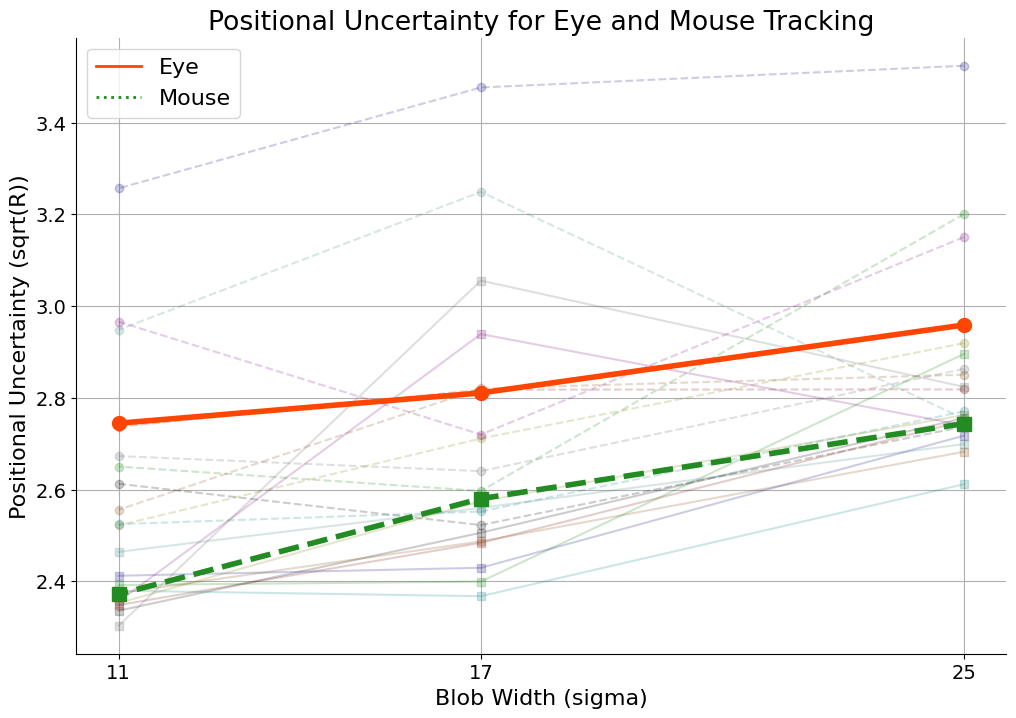

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")
rValMouse = []
rValEye = []
plt.figure(figsize=(12,8))
plt.title('Positional Uncertainty for Eye and Mouse Tracking')
for fileN in range(10):
    randomColorCode = np.random.rand(3,)
    for dataType in ["data_both", "data_eye"]:
        r_values_eye = []
        r_values_both = []
        
        fileIs,sigma, eyeResp, target, targetY,eyeRespY,blob_widths,nTrial,nSigma,nTrialPerSigma,mouseResp,mouseRespY,combinedEyeRespXY,combinedTargetPosXY,combinedMouseRespXY =  load_and_process_data(dataType, 'p'+str(fileN))
        print(fileIs)
        trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp)
  
        print(fileN)
        X = target
        if dataType == "data_both":
            Y = mouseResp
        else:
            Y = eyeResp
            #Y = smooth_data(Y)
        nLLs = []
        i=0
        # Initialize arrays to store results
        r_values = np.zeros(len(blob_widths))
        fval_values = np.zeros(len(blob_widths))
        # Plot setup
        lag=12
        clip=60

        Xc = X[:, clip:X.shape[1] -lag] - np.mean(X[:, clip:X.shape[1]-lag], axis=1)[:, np.newaxis]
        Yc = Y[:, lag+clip:] - np.mean(Y[:, lag+clip:], axis=1)[:, np.newaxis]
        results=[]
        Q=1
        # calculate intirial Guess for Q 
        rr_initial_guess = np.log(100)  # Initial guess for log observation noise variance
        # sigmas is reversed unique values of sigma
        sigmas = np.unique(sigma)[::-1]
        for i in range(len(sigmas)):
            index = [s == sigmas[i] for s in sigma]
            index=np.array(index).flatten()
            #calculate Q for each sigma as a variance of displacement
            result = minimize(negLogLikelihood, rr_initial_guess, args=(Q, Xc[index,:].T, Yc[index,:].T), method='BFGS', options={'maxiter': 1000})
            results.append(result)
            # # Store optimization results
            r_values[i] = np.sqrt(result.x[0])
            fval_values[i] = result.fun
            print('Optimal value for observation noise variance is ' + str(r_values[i]))
            # # Plot the result
            if dataType=="data_both":    
                #plt.semilogx(sigmas[i], r_values[i], 's', linewidth=3, markersize=13, label=f'sigma={sigmas}',color=colors[fileN], alpha=0.7)
                #r_values_both.append(r_values)
                pass
            else:
                pass
                #plt.semilogx(sigmas[i], r_values[i], '.', linewidth=3, markersize=15, label=f'sigma={sigmas}',color=colors[fileN], alpha=0.7)
                #r_values_eye.append(r_values)
        if dataType=="data_both":
            plt.plot(sigmas, r_values, 'k-',color=colors[fileN],label=f'sigma={sigmas}',marker='s',alpha=0.2)
        else:
            plt.plot(sigmas, r_values, 'k--',color=colors[fileN],label=f'sigma={sigmas}',marker='o',alpha=0.2)
        
        #y ticks only show 11, 17, 25
        plt.xticks(sigmas)
        # remove spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.grid(True)

        if dataType=="data_both":
            rValMouse.append(r_values)
            
        else:
            rValEye.append(r_values)
        
#plot avaraged r values for eye

rValEye=np.array(rValEye)
rValMouse=np.array(rValMouse)
rValEyeMean=np.mean(rValEye,axis=0)
rValMouseMean=np.mean(rValMouse,axis=0)
plt.plot(sigmas, rValEyeMean, 'k-',color='orangered',label=f'Eye',marker='o',markersize=10,lw=4)
plt.plot(sigmas, rValMouseMean, 'k--',color='forestgreen',label=f'Mouse',marker='s',markersize=10,lw=4)
eye_line = mlines.Line2D([], [], color='orangered', lw=2, label='Eye')
mouse_line = mlines.Line2D([], [], color='forestgreen', lw=2, linestyle=':', label='Mouse')
lines = [eye_line, mouse_line]
plt.legend(handles=lines, loc='best')

plt.xlabel('Blob Width (sigma)')
plt.ylabel('Positional Uncertainty (sqrt(R))')



""" 
To further retrieve a single better measure of visual uncertainty about the target we fit the Kalman filter to the position data. As we have described in the introduction Kalman filter uses a moving avarage like Bayesian algorithm to estimate the future states of the system. Here we reverse correlate this model using fitting with the given responses and try to retrieve observed noise variance which we refer as positional uncertainty of the target. Here after we will symbolize this parameter as R. 
Kalman filter in the tracking task, provided us two positional values for each frame. The first one is the target position and the second one is the response position of the participant. We used the target position as the true position of the target and the response position as the observed position of the target. We then calculated the positional uncertainty of the target for each blob width using the Kalman filter. 
How do we do that? We first 


 Figure: Positional Uncertainty for Eye and Mouse Tracking
figure captions:
The figure shows the positional uncertainty of the eye and mouse tracking for different blob widths. The x-axis represents the blob width (sigma), and the y-axis represents the positional uncertainty (sqrt(R)). The black solid line represents the positional uncertainty for the eye tracking, and the black dashed line represents the positional uncertainty for the mouse tracking.
The positional uncertainty of the eye tracking is higher than the mouse tracking for all blob widths, indicating that the eye tracking has a higher variability in the response to the motion of the target compared to the mouse tracking. The positional uncertainty of both eye and mouse tracking increases with increasing blob width, indicating that the response to the motion of the target is more variable and less consistent for larger blob widths. The positional uncertainty of the eye tracking is consistently higher than the mouse tracking for all blob widths, indicating that the eye tracking has a higher variability in the response to the motion of the target compared to the mouse tracking.

Figure description in text:

The figure shows the positional uncertainty of the eye and mouse tracking for different blob widths.
The x-axis represents the blob width (sigma), and the y-axis represents the positional uncertainty (sqrt(R)).
The black solid line represents the positional uncertainty for the eye tracking, and the black dashed line represents the positional uncertainty for the mouse tracking.


Figure 9 shows the positional uncertainty of the eye and mouse tracking for different blob widths. The positional uncertainty of the eye tracking is consistently higher than the mouse tracking for all blob widths, indicating that the eye tracking has a higher variability in the response to the motion of the target compared to the mouse tracking. 



"""

In [ ]:
# create df_rvalues with the r values for each participant and blob widths and response mode as a factor
rValEye=rValEye.T
rValMouse=rValMouse.T
df_rvalues = pd.DataFrame(data=rValEye, columns=[f'p{i}' for i in range(10)])
df_rvalues['sigma'] = sigmas
df_rvalues['respMode'] = 'eye'
df_rvalues_mouse = pd.DataFrame(data=rValMouse, columns=[f'p{i}' for i in range(10)])
df_rvalues_mouse['sigma'] = sigmas
df_rvalues_mouse['respMode'] = 'mouse'
df_rvalues_all = pd.concat([df_rvalues, df_rvalues_mouse], axis=0)
df_rvalues_all

# make the df long format

df_rvalues_all_long = pd.melt(df_rvalues_all, id_vars=['sigma', 'respMode'], var_name='participant', value_name='r_value')
df_rvalues_all_long

# save
df_rvalues_all_long.to_csv('df_rvalues_all_long.csv', index=False)

# Fit the ANOVA model for the r values of the eye and mouse tracking take participant as a random factor
model_rvalues = ols('r_value ~ C(sigma) + C(respMode) + C(sigma):C(respMode) + C(participant)', data=df_rvalues_all_long).fit()
anova_results_rvalues = anova_lm(model_rvalues)
print(anova_results_rvalues)


NameError: name 'ols' is not defined

In [ ]:

# do a multiway ANOVA test
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Fit the ANOVA model
model = ols('amplitude ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final).fit()

# Perform the ANOVA
anova_results = anova_lm(model)
print(anova_results)

from statsmodels.multivariate.manova import MANOVA

# Fit the MANOVA model
maov = MANOVA.from_formula('amplitude + lag + width ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final)

# Perform the MANOVA
print(maov.mv_test())



                              df    sum_sq   mean_sq          F    PR(>F)
C(blob_widths)               2.0  0.020116  0.010058  11.191802  0.000081
C(respMode)                  1.0  0.006909  0.006909   7.688154  0.007535
C(blob_widths):C(respMode)   2.0  0.003830  0.001915   2.131127  0.128231
Residual                    56.0  0.050326  0.000899        NaN       NaN


ValueError: Covariance of x singular!

In [ ]:
# Do anova to see if there is a significant difference between the two respMode
# Amplitude
eyeOnly = df_final[df_final['respMode'] == 'eyeOnly']['amplitude']
mouse = df_final[df_final['respMode'] == 'mouse']['amplitude']
anova_amplitude = stats.f_oneway(eyeOnly, mouse)
anova_amplitude

# Lag
eyeOnly = df_final[df_final['respMode'] == 'eyeOnly']['lag']
mouse = df_final[df_final['respMode'] == 'mouse']['lag']
anova_lag = stats.f_oneway(eyeOnly, mouse)
anova_lag

# Width
eyeOnly = df_final[df_final['respMode'] == 'eyeOnly']['width']
mouse = df_final[df_final['respMode'] == 'mouse']['width']
anova_width = stats.f_oneway(eyeOnly, mouse)
anova_width





F_onewayResult(statistic=0.35746426763870043, pvalue=0.5522453669689393)

In [ ]:
# combine df_mouse and df_final
df = pd.concat([df_mouse, df_eyeOnly], axis=0)

# save df_final
#df_final.to_csv('df_final.csv',index=False)
# df_final.to_csv('df_final.csv',index=False)
# # Do anova test
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import anova_lm

# # Fit the model
# model = ols('amplitude ~ C(blob_widths) + C(participant)+C(respMode)', data=df_final).fit()

# # Perform ANOVA
# anova_table = anova_lm(model, typ=2)
# print(anova_table)


NameError: name 'df_mouse' is not defined

In [ ]:
df.describe()
df["participant"]= df["participant"].astype("category")
df["blob_widths"]=df["blob_widths"].astype("category")
df.to_csv('df_final.csv',index=False)

In [ ]:

# Create separate dataframes for 'eyeResp' and 'mouseResp'
eye_df = df[df['respMode']=='eyeOnly'].rename(columns={'lag': 'lag_eye'})
mouse_df = df[df['respMode']=='mouse'].rename(columns={'lag': 'lag_mouse'})

# Merge the dataframes on 'participant' and 'blob_widths'
merged_df = pd.merge(eye_df, mouse_df, on=['participant', 'blob_widths'])

# Plot the data
plt.figure(figsize=(10,6))
sns.scatterplot(x='lag_eye', y='lag_mouse', data=merged_df, hue='blob_widths')
plt.title('Lag of Eye Response vs Mouse Response by Blob Widths')
plt.xlabel('Eye Response')
plt.ylabel('Mouse Response')

In [ ]:

# Create separate dataframes for 'eyeResp' and 'mouseResp'
eye_df = df[df['respMode']=='eye'].rename(columns={'amplitude': 'peak_eye'})
mouse_df = df[df['respMode']=='mouse'].rename(columns={'amplitude': 'peak_mouse'})

# Merge the dataframes on 'participant' and 'blob_widths'
merged_df = pd.merge(eye_df, mouse_df, on=['participant', 'blob_widths'])

# Plot the data
plt.figure(figsize=(10,6))
sns.scatterplot(x='peak_eye', y='peak_mouse', data=merged_df, hue='blob_widths')
plt.title('Peak of Eye Response vsf Mouse Response by Blob Widths')
plt.xlabel('Eye Response')
plt.ylabel('Mouse Response')